In [115]:
import pandas as pd
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt

In [116]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [117]:
## Retrieve Data 
loansData = pd.read_csv('https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv')

In [118]:
## Reset index
loansData = loansData.reset_index(drop = True)
loansData.head()

,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,20000,20000,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14,14272,2,< 1 year
1,19200,19200,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12,11140,1,2 years
2,35000,35000,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14,21977,1,2 years
3,10000,9975,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10,9346,0,5 years
4,12000,12000,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11,14469,0,9 years


In [119]:
## Utility functions to clean up data

def int_rate(dt):
    dt = str(dt).strip('%')
    if float(dt) < 12.0:
        return 0
    else:
        return 1
    
def fico_score(dt):
    return int(dt.split('-')[0])

In [120]:
df = loansData[['Interest.Rate', 'Amount.Requested']]

In [121]:
df['Interest.Rate'] = df['Interest.Rate'].apply(int_rate)
df['FICO.Score'] = loansData['FICO.Range'].apply(fico_score)
df['Intercept'] = 1.0

/Users/ikeokonkwo/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ikeokonkwo/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/ikeokonkwo/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [122]:
df.head()

,Interest.Rate,Amount.Requested,FICO.Score,Intercept
0,0,20000,735,1
1,1,19200,715,1
2,1,35000,690,1
3,0,10000,695,1
4,0,12000,695,1


In [123]:
##  train logistic regression with data 
ind_vars = ['FICO.Score', 'Amount.Requested', 'Intercept']
logit = sm.Logit(df['Interest.Rate'], df[ind_vars])
result = logit.fit()
coeff = result.params
print(coeff)

Optimization terminated successfully.
         Current function value: 0.319503
         Iterations 8
FICO.Score          -0.087423
Amount.Requested     0.000174
Intercept           60.125045
dtype: float64


In [124]:
## Calculate the interest rate given FIC0 score and Amount Request

def calc_int_rate(params, fico_score, loan_amount):
    '''
    Calculate interest rate given FIC0 score and Amount Request
    '''
    interest_rate =  params['Intercept'] + params['FICO.Score'] * fico_score + params['Amount.Requested'] * loan_amount
    return abs(interest_rate)

# example
calc_int_rate(coeff, 735, 20000)

0.65045887580957595

In [125]:
def logistic_function_proba(interest_rate):
    '''
    Output log-odds from logistic function for a given interest rate 
    '''
    p = 1/(1 + math.exp(-(interest_rate)))  
    return p

# example
logistic_function_proba(0.650)

0.6570104626734988

Generate x and y data to plot the sigmoid curve

In [126]:
x = range(-1000,1600)

In [127]:
x_ = [i/100. for i in x]
y_ = [logistic_function_proba(i) for i in x_ ]

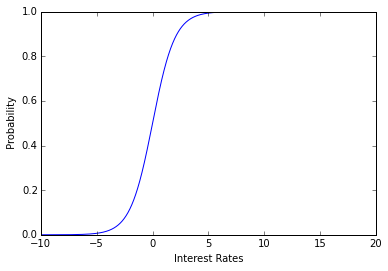

In [128]:
# plot data 
plt.plot(x_, y_)
plt.ylabel(' Probability')
plt.xlabel('Interest Rates')
plt.show()